### Objective
 Organize and analyse data from plate readers experiments. At a initial approach it is to analize inverters genetic circuits. It have to save processed data and be able to work with the full data experiments (not only with one book at time) 

### requirements:
 * have the data organized in a xls file.


In [2]:
# import general packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# import xls manager package manager
import openpyxl as opxl

In [ ]:
# import plate reader data manager package
#import platemanage as plate

Then we are ready to loas the data from the xls book files:

In [4]:
#load the data 
wb = opxl.load_workbook(filename = 'Raw_data/RV1 - python.xlsx')
#get the sheet names
sheets = wb.sheetnames
print(sheets)

# to get a sheet call them as: OD600sheet = wb['OD600']

['Plate 1 - Sheet1', 'OD600', 'CFP', 'YFP', 'Strains', 'Inductor', 'Media']


In [5]:
#dimensionando los datos:
#in the cell mode of datasheet index start from 1 not from 0 as usually in python

def sheet_size(sheet, rc0=[1,1]): 
    """
    This function aims to size the data present in a sheet. The sizing is performed in a fixed position given by the user (rc0).
    It means if rc0=[1,1] the column counting will be done in the first row and the row counting will be done in the first column.
    
    Parameters
    ----------
    sheet: workbook sheet
        sheet file to be sized
    
    rc0: numeric list
        [row number, colmun number] fixed positions where perform the count
        
    
    Returns
    -------        
    rows: integer
        number of rows counted in the sheet
    
    columns: integer
        number of columns counted in the sheet
        
    """
    rows = 1 
    columns = 1
        
    while True:
        if sheet.cell(row=rows+1, column=rc0[1]).value != None: 
            rows+=1
        else:
            break
    while True:
        if sheet.cell(row=rc0[0], column=columns+1).value != None:
            columns+=1
        else:
            break
    #print(str(rows) + ' rows') 
    #print(str(columns) + ' columns')
    return(rows,columns)

We are interested in the size of the sheets OD600, YFP and CFP (and will call them *data_sheets*)

In [6]:
data_sheets = sheets[1 : 4]
for namesheet in data_sheets:
    print(namesheet+': ')
    print(sheet_size(wb[namesheet]))
    print('\n')

OD600: 
(146, 98)


CFP: 
(146, 98)


YFP: 
(146, 98)




The data in the sheets include headers and specials columns as _Time_ and _Temperature_. To split them we have to indicate the position where wells data start.

In [7]:
start_row=input('Enter the data starting row number ')
print('data start in row '+ start_row)
start_column=input('Enter the data starting column number ')
print('data start in column '+ start_column)

Enter the data starting row number 2
data start in row 2
Enter the data starting column number 3
data start in column 3


With this values we are able to determine the real size of the data wells:

In [8]:
srow=int(start_row)
scolumn=int(start_column)

ncolumns=sheet_size(wb[sheets[1]])[1]- scolumn + 1
print('wells = ' + str(ncolumns) )
timepoints=sheet_size(wb[sheets[1]])[0]- srow + 1
print('time points = ' + str(timepoints))

wells = 96
time points = 145


Now we should be able to get the values of each dataset

In [9]:
def get_values(ws, row_start, column_start, time_column=1, header_row=1):
    """
    To get the wells data from a worksheet
    
    Parameters
    ----------
    ws: worksheet
        sheet file to get the data
    
    row_start: int
        row where wells data started
        
    
    Returns
    -------
    data: numpy array
        wells experimental measurements
        
    time: numpy vector
        time points values in hours units
    
    header: str
        header of each well data (usually 'A1','A2', etc)
        
    """
    
    rows, columns=sheet_size(ws)    
    data= np.zeros((rows-row_start+1,columns-column_start+1))
    time = np.zeros((rows-row_start+1))
    headers = []
    for i in range(rows-row_start+1):
        
        time_aux = ws.cell(row=i+row_start, column=time_column).value
        
        #transform time values in hour fractions units
        if type(time_aux)==float:
            time[i] = time_aux*24
        else:
            time[i] =time_aux.hour + time_aux.minute/60 + time_aux.second/3600
            
                
        for j in range(columns-column_start+1):
            data[i,j]=ws.cell(row=i+row_start, column=j+column_start).value
            if i==0:
                headers.append(ws.cell(row=header_row, column=j+column_start).value)  # list with the headers
    #print(headers)
    return(data,time,headers)

In [10]:
wdata={}
for namesheet in data_sheets:
    wdata[namesheet] = {} 
    data, time, header = get_values(wb[namesheet],srow,scolumn,1,1)
    wdata[namesheet]['data'] = data
    wdata[namesheet]['time'] = time
    wdata[namesheet]['header'] = header
    

Be carefull at get the size of header, beacause it is a list and then you have to use `len()` to know his shape

In [17]:
print(wdata[data_sheets[1]]['data'].shape)
print(wdata[data_sheets[1]]['time'].shape[0])
print(len(wdata[data_sheets[1]]['header']))

(145, 96)
145
96


Now, we should get the different labels assigned to each well:

In [18]:
def get_label_values(ws,row_start,column_start):
    rows,columns=sheet_size(ws)    
    if type(ws.cell(row=row_start, column=column_start).value) == str:
        values = []
        for i in range(rows-row_start+1):
            values_col=[]         
            for j in range(columns-column_start+1):
                values_col.append(ws.cell(row=i+row_start, column=j+column_start).value)
            values.append(values_col)  
    
    else:   #in case data is not string
        values= np.zeros((rows-row_start+1,columns-column_start+1))
    
        for i in range(rows-row_start+1):
                      
            for j in range(columns-column_start+1):
                values[i,j]=ws.cell(row=i+row_start, column=j+column_start).value

    return(values)    

In [19]:
L_start_row=input('Enter the label starting row number ')
print('data start in row '+ L_start_row)
L_start_column=input('Enter the label starting column number ')
print('data start in column '+ L_start_column)

Enter the label starting row number 2
data start in row 2
Enter the label starting column number 2
data start in column 2


And as we could expect, it is 8 by 12 size

In [20]:
print(len(get_label_values(wb[sheets[4]],int(L_start_row),int(L_start_column))))
print(len(get_label_values(wb[sheets[4]],int(L_start_row),int(L_start_column))[1]))

8
12


In [21]:
# labels are in:
L_sheets=sheets[4:]
print(L_sheets)

['Strains', 'Inductor', 'Media']


In [22]:
wlabels={}
for namesheet in L_sheets:
    wlabels[namesheet] = get_label_values(wb[namesheet],int(L_start_row),int(L_start_column))   

In [34]:
wlabels[L_sheets[0]]

[['pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan'],
 ['pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan',
  'pSrpR-S3_cyan'],
 ['pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan'],
 ['pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan',
  'pAN1717_cyan'],
 ['pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',
  'pAN1818_cyan',


Now, we can start to plot the data:

In [24]:
wdata[data_sheets[0]]['time']

array([  0.125     ,   0.29166667,   0.45833333,   0.625     ,
         0.79166667,   0.95833333,   1.125     ,   1.29166667,
         1.45833333,   1.625     ,   1.79166667,   1.95833333,
         2.125     ,   2.29166667,   2.45833333,   2.625     ,
         2.79166667,   2.95833333,   3.125     ,   3.29166667,
         3.45833333,   3.625     ,   3.79166667,   3.95833333,
         4.125     ,   4.29166667,   4.45833333,   4.625     ,
         4.79166667,   4.95833333,   5.125     ,   5.29166667,
         5.45833333,   5.625     ,   5.79166667,   5.95833333,
         6.125     ,   6.29166667,   6.45833333,   6.625     ,
         6.79166667,   6.95833333,   7.125     ,   7.29166667,
         7.45833333,   7.625     ,   7.79166667,   7.95833333,
         8.125     ,   8.29166667,   8.45833333,   8.625     ,
         8.79166667,   8.95833333,   9.125     ,   9.29166667,
         9.45833333,   9.625     ,   9.79166667,   9.95833333,
        10.125     ,  10.29166667,  10.45833333,  10.62

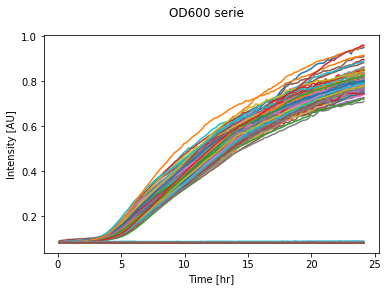

In [25]:
# put here the data name you are interested
data_name=data_sheets[0]    #only change the number inside []

# now it will be plot
fig= plt.figure()
fig.suptitle(data_name +' serie')
plt.plot(wdata[data_name]['time'], wdata[data_name]['data'])
plt.ylabel('Intensity [AU]')
plt.xlabel('Time [hr]')
#plt.axis([0, 6, 0, 20])
plt.show()

In [149]:
def plot_group(wsd, wsl, datasheets, index_data, index_label, label_cath, y_axis_lab):
    (wdata, wlabels, data_sheets, index_D, index_L, legend_labels, y_axis_labels)
    """
    Plot the data from 'wsd' of wells indicated on 'index_data' putting the labels from 'label_cath' whos positions
    are indicated in 'index_label'.  
    
    Parameters
    ----------
    wsd: dictionary
        contain the data values of each well
    
    wsl:dictionary
        contain the labels of each well
        
    datasheets: list
        list of datasheet names. If you only put one name, make sure to make it a list
        e.g. ['sheet_name'] and not only 'sheetname'
    
    index_data: list
        contain the index of the selected data wells.
        can be obtained with get_group_index or set manually
        
    index_label: list
        coordinates of the selected wells in the label sheets
        can be obtained with get_group_index or set manually
    
    label_cath: list
        sheet names of the cathegories to use in the labels
    
    y_axis_lab: list
        y axis labels to write in the plots. It have to be in the same order
        as the data is included. 
        e.g: y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']
        
    
    Returns
    -------
    data: numpy array
        wells experimental measurements
        
    time: numpy vector
        time points values in hours units
    
    header: str
        header of each well data (usually 'A1','A2', etc)
        
    """
        
    data = {}
    labels = []
    ind_len = len(index_data)
    
    for name in datasheets:
        # make a list with arrays of zeros with the size of each dataset
        data[name] = np.zeros((wsd[name]['time'].shape[0], ind_len))

        # assign the corresponding values to each array
        for i in range(ind_len):
            data[name][:,i]=wsd[name]['data'][:,index_data[i]]
            
            # get the labels of the selected wells - datasets
            label_string=''
            for cat in label_cath:
                
                label_name = str(wsl[cat][index_label[i][0]][index_label[i][1]])
                
                if label_string == '':
                    label_string = label_name
                else:
                    label_string = label_string + ' , ' + label_name
            
            labels.append(label_string)    
        
    print(labels)
    # make a list of non-redundant labels
    nr_labels=[]
    for label in labels:
        if label not in nr_labels:
            nr_labels.append(label)
    
    # define a color vector for labels
    colors = plt.cm.jet(np.linspace(0, 1, len(nr_labels)))
    
    # make plots
    for name,m in zip(datasheets, range(len(y_axis_lab))):
        fig= plt.figure()
        fig.suptitle(name + ' series')
        plot_lines = []
        time=wsd[name]['time']
        
        for j in range(ind_len):
            lab_num = nr_labels.index(labels[j])       # get the position if the label in the non-redundant label list
            p=plt.plot(time, data[name][:,j], color=colors[lab_num])
            plot_lines.append(p)
        
        plt.ylabel(y_axis_lab[m])
        plt.xlabel('Time [hr]')
        #plt.axis([0, 6, 0, 20])
        plt.legend([nr_labels[i] for i in range(len(nr_labels))], loc = 'upper right', bbox_to_anchor=(1.3, 1))
        plt.show()


It's neccesary to define the blank data sets for OD600 and fluorescence to substract them to the rest of the data:

In [138]:
def get_group_index(label_groups, wsl, label_sheetnames):
    """
    Return the data index (well number) and the label index (label position) of the
    wells whose label coincide with at least one label of 'label_groups' (OR logic)
    In the future should be modified to choose between OR / AND logic classification
    accord the groups indicated in 'label_groups'
    
    Parameters
    ----------
    label_groups: list of strings
        contain the cathegories whose data sets are desired to select
        
    wsl: dictionary
        cointain the data from the workbook label sheets
    
    label_sheetnames: list of strings
        contain the names of the sheets with the labels
        
    
    Returns
    -------
    index_data: list
        contain the index of the selected data wells
        
    index_label: list
        coordinates of the selected wells in the label sheets
        
    """
    index_data=[]
    index_label=[]

    for cat in label_groups:
        for name in label_sheetnames:
            counter=0
            labels = wsl[name]
            for i in range(len(labels)):
                for j in range(len(labels[0])):
                    if cat == labels[i][j]:
                        index_data.append(counter)
                        index_label.append([i,j])
                    counter+=1    
    print(index_data)
    print(index_label)
    return(index_data, index_label)

[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
[[7, 0], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 10], [7, 11]]
['1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '100.0 , M9 Glicerol', '50.0 , M9 Glicerol', '10.0 , M9 Glicerol', '0.0 , M9 Glicerol', '1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '100.0 , M9 Glicerol', '50.0 , M9 Glicerol', '10.0 , M9 Glicerol', '0.0 , M9 Glicerol']


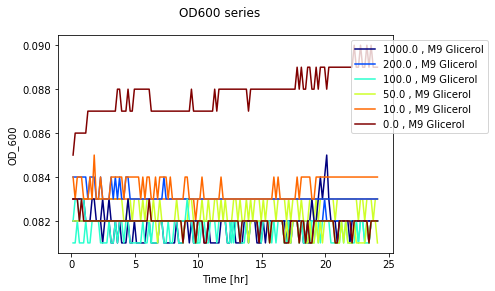

In [162]:
#define the OD blank data series
B_labels=['Blanco','Blanco +Kan']  #fill this list manually

# and get the wells index which have that lalbels
index_D, index_L = get_group_index(B_labels, wlabels, L_sheets)

#Perform the plots of blank series data
legend_labels = [L_sheets[1], L_sheets[2]]
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']

plot_group(wdata, wlabels, [data_sheets[0]], index_D, index_L, legend_labels, y_axis_labels)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11]]
['1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '150.0 , M9 Glicerol', '100.0 , M9 Glicerol', '70.0 , M9 Glicerol', '50.0 , M9 Glicerol', '40.0 , M9 Glicerol', '30.0 , M9 Glicerol', '20.0 , M9 Glicerol', '10.0 , M9 Glicerol', '5.0 , M9 Glicerol', '0.0 , M9 Glicerol', '1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '150.0 , M9 Glicerol', '100.0 , M9 Glicerol', '70.0 , M9 Glicerol', '50.0 , M9 Glicerol', '40.0 , M9 Glicerol', '30.0 , M9 Glicerol', '20.0 , M9 Glicerol', '10.0 , M9 Glicerol', '5.0 , M9 Glicerol', '0.0 , M9 Glicerol', '1000.0 , M9 Glicerol', '200.0 , M9 Glicerol', '150.0 , M9 Glicerol', '100.0 , M9 Glicerol', '70.0 , M9 Glicerol', '50.0 , M9 Glicerol', '40.0 , M9 Glicerol', '30.0 , M9 Glicerol', 

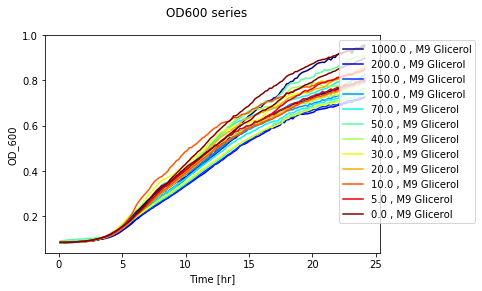

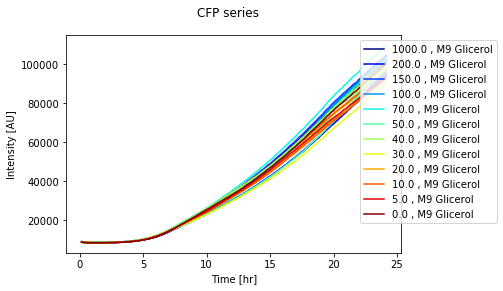

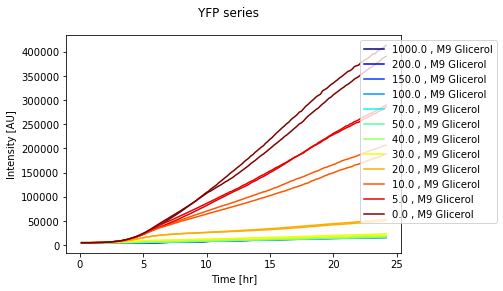

In [157]:
srp_labels=['pSrpR-S3_cyan']  #fill this list manually

# and get the wells index which have that lalbels
index_D, index_L = get_group_index(srp_labels, wlabels, L_sheets)

#Perform the plots of blank series data
legend_labels = [L_sheets[1], L_sheets[2]]
y_axis_labels = ['OD_600', 'Intensity [AU]', 'Intensity [AU]']

plot_group(wdata, wlabels, data_sheets, index_D, index_L, legend_labels, y_axis_labels)

In [ ]:
from scipy.optimize import curve_fit